In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import plot_roc_curve

%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('data/Task2data.csv')
y = df.pop('fraud')

In [3]:
X_main, X_holdout, y_main, y_holdout = train_test_split(df, y, random_state=7, stratify=y)

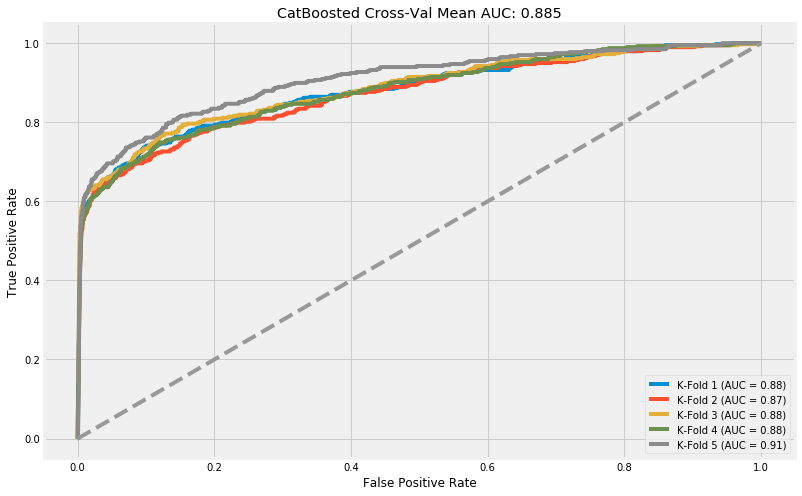

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))

kf = StratifiedKFold(n_splits=5, shuffle=True)

feats = ['zip1', 'id#']
cbc = CatBoostClassifier(verbose=False)

AUCs = []

for i, (train_index, test_index) in enumerate(kf.split(X_main, y_main)):
    X_train, X_test = X_main.iloc[train_index], X_main.iloc[test_index]
    y_train, y_test = y_main.iloc[train_index], y_main.iloc[test_index]
    
    cat_pool = Pool(X_train, y_train, cat_features=feats)
    cbc.fit(cat_pool)
    
    plot_roc_curve(cbc, X_test, y_test.values, name=f'K-Fold {i+1}', ax=ax)
    AUCs.append(metrics.roc_auc_score(y_test.values, cbc.predict_proba(X_test)[:,1]))
    
mean_auc = round(np.mean(AUCs), 3)
ax.set_title(f'CatBoosted Cross-Val Mean AUC: {mean_auc}')  
ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')

In [6]:
import pickle 
cat_pool = Pool(X_main, y_main, cat_features=feats)
cbc.fit(cat_pool)
with open('models/xgboost.pkl', 'wb') as f:
    pickle.dump(cbc, f)